<a href="https://colab.research.google.com/github/probml/JSL/blob/main/jsl/demos/kalman_sampling_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --upgrade git+https://github.com/google/flax.git
!pip install --upgrade tensorflow-probability
!pip install git+https://github.com/blackjax-devs/blackjax.git
!pip install git+https://github.com/deepmind/distrax.git




  Cloning https://github.com/google/flax.git to /tmp/pip-req-build-0hwmt6g7
  Running command git clone -q https://github.com/google/flax.git /tmp/pip-req-build-0hwmt6g7
     |████████████████████████████████| 140 kB 26.5 MB/s 
     |████████████████████████████████| 72 kB 652 kB/s 
  Created wheel for flax: filename=flax-0.4.1-py3-none-any.whl size=186136 sha256=d5342ce8fc05dd73f0d01481e21ff3a682569ac0590c7d85a087d7e2d9c4b1e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-wxzz5v1l/wheels/3e/9e/df/f792f5b2c0d0ccf00f3c1286bc060dab7cb2a4af5134d1c5b4
Successfully built flax
  Cloning https://github.com/blackjax-devs/blackjax.git to /tmp/pip-req-build-oti4y44s
  Running command git clone -q https://github.com/blackjax-devs/blackjax.git /tmp/pip-req-build-oti4y44s
  Created wheel for blackjax: filename=blackjax-0.4.0-py3-none-any.whl size=77597 sha256=4799295243baf5fd17b8c418402030f792e6fa602de320d7853a3c665ed35298
  Stored in directory: /tmp/pip-ephem-wheel-cache-1o74sggy/wheels/8f/53/9

In [3]:
!git clone https://github.com/probml/JSL.git
%cd JSL
!pip install -e .

Cloning into 'JSL'...
remote: Enumerating objects: 1881, done.
remote: Counting objects: 100% (1881/1881), done.
remote: Compressing objects: 100% (609/609), done.
remote: Total 1881 (delta 1254), reused 1854 (delta 1242), pack-reused 0
Receiving objects: 100% (1881/1881), 6.57 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (1254/1254), done.
/content/JSL
Obtaining file:///content/JSL
  Running setup.py develop for jsl


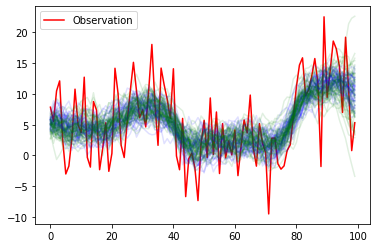

In [4]:
%run jsl/demos/lds_sampling_demo.py


In [19]:

import jax   
from cProfile import label
import jax.numpy as jnp
from jax.random import  PRNGKey
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
import matplotlib.pyplot  as plt

from jsl.lds.kalman_filter import LDS, kalman_filter
from jsl.lds.kalman_sampler import smooth_sampler


In [28]:
# tensorflow_probability
ndims = 1
step_std = 1.0
noise_std = 5.0
model = tfd.LinearGaussianStateSpaceModel(
  num_timesteps=100,
  transition_matrix=tf.linalg.LinearOperatorDiag(jnp.array([1.01])),
  transition_noise=tfd.MultivariateNormalDiag(
   scale_diag=step_std * tf.ones([ndims])),
  observation_matrix=tf.linalg.LinearOperatorIdentity(ndims),
  observation_noise=tfd.MultivariateNormalDiag(
   scale_diag=noise_std * tf.ones([ndims])),
  initial_state_prior=tfd.MultivariateNormalDiag(loc=jnp.array([5.0]),
   scale_diag=tf.ones([ndims])))

# Sample 1 sequence from the prior of the LDS
y = model.sample(seed=(1,2)) 

nsamples = 2000

smps = model.posterior_sample(y, sample_shape=nsamples)
s_tf = jnp.array(smps[:,:,0])

mean_tf = jnp.mean(s_tf, axis=0)

print(s_tf.shape)
print(mean_tf.shape)

(2000, 100)
(100,)


In [29]:
# Define the same model as an LDS object defined in the kalman_filter file 
A = jnp.eye(1) * 1.01
C = jnp.eye(1)
Q = jnp.eye(1)
R = jnp.eye(1) * 25.0
mu0 = jnp.array([5.0])
Sigma0 = jnp.eye(1)
model_lds = LDS(A, C, Q, R, mu0, Sigma0)
# Run the Kalman filter algorithm first
mu_hist, Sigma_hist, mu_cond_hist, Sigma_cond_hist = kalman_filter(model_lds, jnp.array(y))
# Sample backwards using the smoothing posterior
smooth_sample = smooth_sampler(model_lds, PRNGKey(0), mu_hist, Sigma_hist, n_samples=nsamples)
s_jax = smooth_sample[:,:,0]

mean_jax = jnp.mean(s_jax, axis=0)

print(s_jax.shape)
print(mean_jax.shape)

(2000, 100)
(100,)


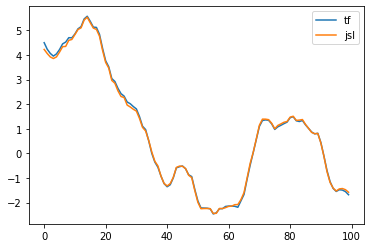

In [30]:

plt.figure()
plt.plot(mean_tf, label='tf')
plt.plot(mean_jax, label='jsl')
plt.legend()
plt.show()

In [31]:
jnp.max(mean_tf - mean_jax)

DeviceArray(0.27465248, dtype=float32)

In [32]:
mean_tf - mean_jax

DeviceArray([ 0.27465248,  0.1736412 ,  0.14441681,  0.0984354 ,
              0.12129331,  0.10304689,  0.11484623,  0.17503166,
              0.10844803,  0.06539965,  0.02367926,  0.02893591,
              0.04644346,  0.04540443,  0.03775024,  0.05934906,
              0.03860378,  0.08240652,  0.07577753,  0.08367157,
              0.06808376,  0.05231547,  0.07461023,  0.0740571 ,
              0.10213566,  0.11476636,  0.05582666,  0.12515938,
              0.13173628,  0.11065626,  0.08664942,  0.07616603,
              0.04648519,  0.05761021, -0.00808275, -0.05528012,
             -0.03191137, -0.05396998,  0.00223547, -0.00743341,
             -0.03241956, -0.04502571, -0.02139676, -0.01694328,
             -0.02482587,  0.01200032, -0.00702184,  0.01766813,
              0.04407704,  0.04392493,  0.05775714,  0.03118992,
              0.01846123,  0.01203752, -0.00659704, -0.01738477,
              0.0208261 , -0.01097298, -0.00208759,  0.0481286 ,
              0.01110792,